<a href="https://colab.research.google.com/github/JotaMTB/Python_exercises/blob/master/CARS_Marketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Marketing Campaign

El siguiente documento registra el trabajo orientado a preparar una campaña de marketing para la venta de vehículos a un colectivo formado por casi 6.000 personas.

Se tienen datos del sexo, ingresos anuales, clasificación del lugar en el que viven (urbano, semiurbano y rural) y estado civil (casado, divorciado, soltero).

En base a los datos anteriores se realizará una tarea de clustering con el fin de obtener diferentes segmentaciones (previsiblemente entre 4 y 8) para optimizar qué tipo de publicidad  sobre un determinado tipo de vehículo se hace llegar a cada persona.

Notas:
* El dataset de trabajo proviene de la limpieza y filtrado de otro dataset.
* La fuente del dataset orignal es: https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data
* El dataset original no tenía como finalidad la propuesta en este ejercicio, por ese motivo fue filtrado y modificado.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Primer paso: lectura del dataset.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/JotaMTB/Archivos_auxiliares/master/Marketing_campaign.csv')
data.head()

,Unnamed: 0,Customer,Gender,Income,Location Code,Marital Status
0,0,BU79786,F,56274,Suburban,Married
1,2,AI49188,F,48767,Suburban,Married
2,4,HB64268,M,43836,Rural,Single
3,5,OC83172,F,62902,Rural,Married
4,6,XZ87318,F,55350,Suburban,Married


In [ ]:
#Tamaño del dataset:

data.shape

(6817, 6)

#### Eliminación de columnas
* Se elimina la primera columna por ser herencia de las modificaciones previas sobre otro dataset.

* De acuerdo a las indicaciones de los expertos de marketing de la empresa, también se puede eliminar la columna 'Gender' ya que el feedback de campañas anteriores ha sido que no hay apenas diferencia de gustos entre hombres y mujeres a la hora de elegir coche, y dependen más los ingresos (es la principal característica a tener en cuenta), si se vive en un entorno rural o no o si se es soltero o no.

In [ ]:
data.columns.values

array(['Unnamed: 0', 'Customer', 'Gender', 'Income', 'Location Code',
       'Marital Status'], dtype=object)

In [ ]:
columns_out = ['Unnamed: 0', 'Gender']

data = data.drop(columns_out, axis=1)
data.head()

,Customer,Income,Location Code,Marital Status
0,BU79786,56274,Suburban,Married
1,AI49188,48767,Suburban,Married
2,HB64268,43836,Rural,Single
3,OC83172,62902,Rural,Married
4,XZ87318,55350,Suburban,Married


#### Limpieza de filas que estén totalmente vacías:

In [ ]:
data = data.dropna(axis=0, how='all')
data.shape

(6817, 3)

#### Comprobación de falta de valores en alguna columna:

In [ ]:
pd.isnull(data["Income"]).values.ravel().sum()

0

In [ ]:
pd.isnull(data["Location Code"]).values.ravel().sum()

0

In [ ]:
pd.isnull(data["Marital Status"]).values.ravel().sum()

0

Todas las columnas tienen todos los campos rellenos con valores no nulos.

#### Generar columnas dummies
Las columnas ['Gender', 'Location Code', 'Marital Status'] son categóricas, vamos a pasarlas a numéricas con ayuda de las variables dummy.

In [ ]:
columns_to_dummy = ['Location Code', 'Marital Status']   #lista que guarda el nombre de la columnas que se van a transformar en dummy.

def dummy_generator(dataframe, columns_list):   #la función pide un DF y una lista.
    
    for column in columns_list:
        col_dummies = pd.get_dummies(dataframe[column], prefix=column)   #almacena las columnas dummy.
        dataframe = dataframe.join(col_dummies)           #se añaden las nuevas columnas dummy al DF de partida.

    dataframe = dataframe.drop(columns_list, axis=1)      #se eliminar las columnas de partida en el DF.
    return dataframe


data = dummy_generator(data, columns_to_dummy)    #Para obtener el DF modificado, se iguala a la función generadora.

In [ ]:
data.head()

,Customer,Income,Location Code_Rural,Location Code_Suburban,Location Code_Urban,Marital Status_Divorced,Marital Status_Married,Marital Status_Single
0,BU79786,56274,0,1,0,0,1,0
1,AI49188,48767,0,1,0,0,1,0
2,HB64268,43836,1,0,0,0,0,1
3,OC83172,62902,1,0,0,0,1,0
4,XZ87318,55350,0,1,0,0,1,0


Nuevamente es necesario eliminar algunas columnas. Además de la columna de ingresos (Income), permanecerán únicamente las columnas *Location Code_Rural* y *Marital Status_Single*, ya que son las que más peso tienen a la hora de preferir un modelo u otro de coche.

In [ ]:
columns_out = ['Location Code_Suburban', 'Location Code_Urban', 'Marital Status_Divorced', 'Marital Status_Married']

data = data.drop(columns_out, axis=1)
data.head()

,Customer,Income,Location Code_Rural,Marital Status_Single
0,BU79786,56274,0,0
1,AI49188,48767,0,0
2,HB64268,43836,1,1
3,OC83172,62902,1,0
4,XZ87318,55350,0,0


#### Normalización del DataFrame
Para que todos los valores estén entre 0 y 1. En caso contrario, la columna 'Income' tendría todo el peso en la generación de los clusters, ya que el orden de magnitud de los valores de esta columna es muy superior a la del resto.

* También se aprovecha este momento para eliminar la columna 'Customer' del Dataframe de trabajo.

In [ ]:
data_norm = data.drop('Customer', axis=1)
data_norm.head()

,Income,Location Code_Rural,Marital Status_Single
0,56274,0,0
1,48767,0,0
2,43836,1,1
3,62902,1,0
4,55350,0,0


In [ ]:
data_norm = (data_norm-data_norm.min())/(data_norm.max()-data_norm.min())
data_norm.head()

,Income,Location Code_Rural,Marital Status_Single
0,0.514064,0.0,0.0
1,0.430601,0.0,0.0
2,0.375778,1.0,1.0
3,0.587755,1.0,0.0
4,0.503791,0.0,0.0


In [ ]:
#Visualización de cómo han quedado los valores de la columna 'Income' tras ser normalizados:

data_norm['Income'].describe()

count    6817.000000
mean        0.449386
std         0.270234
min         0.000000
25%         0.204516
50%         0.422974
75%         0.668749
max         1.000000
Name: Income, dtype: float64

#### Comienza el trabajo de creación de los *CLUSTERS*

* Obtención del dendrograma para observar el número adecuado de clusters.
* Comprobación con el método del codo.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [ ]:
#Obtención de la matriz de distancias:

Z = linkage(data_norm, "ward")

In [ ]:
#Valor del coeficiente cofenético:

c, coph_dist = cophenet(Z, pdist(data_norm))
c

0.9220549425846444

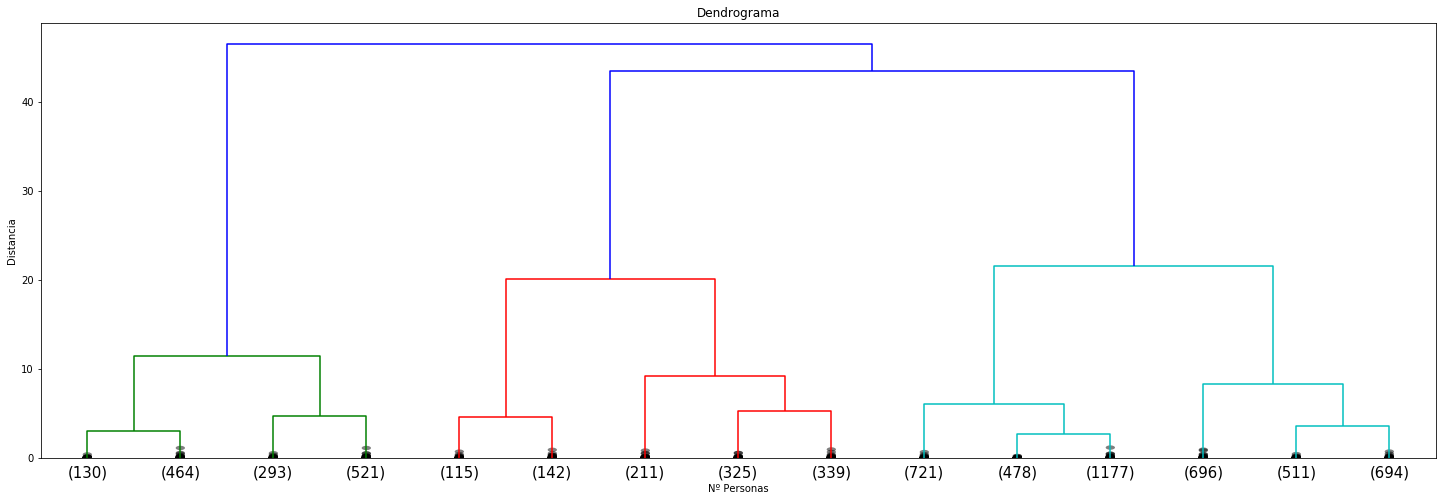

In [ ]:
#Obtención del dendrograma:

plt.figure(figsize=(25,8))
plt.title("Dendrograma")
plt.xlabel("Nº Personas")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=0., leaf_font_size=15.0, truncate_mode="lastp", p=15, show_leaf_counts=True,
           show_contracted=True) #'p=' cambia el nº de sub-cluster a mostrar.
plt.show()

De un primer vistazo se observan 3 grandes grupos, aunque también podría considerarse generar 5 o 6 clusters.

[46.51171569 43.39721562 21.59050565 20.10242752 11.43129016  9.14104359
  8.34320501  6.06857848  5.26691965  4.72156015  4.62330735  3.53798073
  3.00741827  2.70260945  2.5871895 ]


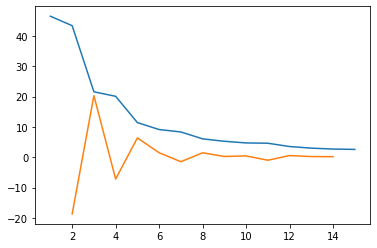

El número óptimo de cluster es 3


In [ ]:
#Método del codo:

last = Z[-15:,2]
last_rev = last[::-1]
print(last_rev)
idx = np.arange(1, len(last)+1)
plt.plot(idx, last_rev)

#Aceleración:
acc = np.diff(last,2)
acc_rev = acc[::-1]
plt.plot(idx[:-2]+1, acc_rev)
plt.show()
k = acc_rev.argmax() +2
print("El número óptimo de cluster es %s"%str(k))

Se procede con una primera segmentación de 3 grupos (clusters) y se analizarán sus características. ¿Estarán suficientemente definidos los clusters?

In [ ]:
from scipy.cluster.hierarchy import fcluster

In [ ]:
##Usando el nº de cluster 'k':

k = 3
clusters = fcluster(Z, k, criterion="maxclust")

data_cluster = data.copy()

data_cluster['Cluster'] = clusters
data_cluster.head()

,Customer,Income,Location Code_Rural,Marital Status_Single,Cluster
0,BU79786,56274,0,0,3
1,AI49188,48767,0,0,3
2,HB64268,43836,1,1,2
3,OC83172,62902,1,0,1
4,XZ87318,55350,0,0,3


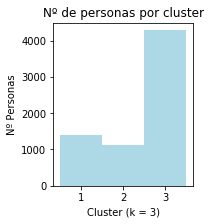

In [ ]:
#Histograma: número de personas en cada cluster:

plt.figure(figsize=(2.5, 3))
plt.hist(data_cluster['Cluster'], align='left', color='lightblue', bins=[1,2,3,4])
plt.xlabel('Cluster (k = 3)')
plt.ylabel('Nº Personas')
plt.title('Nº de personas por cluster')
plt.show()

En primera instancia es claro observar que uno de los clusters (el tercero), agrupa a un número de personas 3 veces superior a cualquier de los otros dos clusters.

In [ ]:
data_cluster.groupby('Cluster').mean()

,Income,Location Code_Rural,Marital Status_Single
Cluster,,,
1,59810.303267,1.000000,0.0
2,49578.435512,0.227032,1.0
3,47609.729483,0.000000,0.0


In [ ]:
data_cluster.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
1,1408.0,59810.303267,22591.387098,10074.0,40515.25,61355.5,77880.50,99875.0
2,1132.0,49578.435512,24151.226967,10037.0,28720.50,48377.0,68051.25,99816.0
3,4277.0,47609.729483,24132.492274,10147.0,26056.00,43259.0,66676.00,99981.0


Observando las dos tablas anteriores se desprenden las siguientes conclusiones:
* Los ingresos para las personas de los 3 clusters son similares. Esto no es nada beneficioso, ya que será imposible atribuir diferentes gamas de producto (coches en este caso) en función de esta característica.
* La definición de los clusters responde claramente al lugar de residencia y al estado civil, y como se ha visto, los ingresos influyen poco en la generación de los grupos o clusters.
* El resumen de los clusters podría ser:
    * Cluster-1: personas que viven en un entorno rural y que no están solteras.
    * Cluster-2: personas solteras y que mayoritariamente (77%) no viven en un entorno rural.
    * Cluster-3: personas que no viven en un entorno rural y que no están casadas.
    

Ya que es sabido que el factor con más importancia a la hora de comprar un coche son los ingresos, vamos a asignarle más peso en el DataFrame. Para ello, multiplico por 5 su valor en el DF normalizado con el fin de balancearlo.

In [ ]:
data_balance = data_norm.copy()

In [ ]:
income = data_balance['Income'].values.tolist()

for i, n in enumerate(income):
    income[i] = n*5

data_balance['Income'] = income
    
data_balance.head()

,Income,Location Code_Rural,Marital Status_Single
0,2.570322,0.0,0.0
1,2.153006,0.0,0.0
2,1.878891,1.0,1.0
3,2.938773,1.0,0.0
4,2.518956,0.0,0.0


In [ ]:
data_balance.describe()

,Income,Location Code_Rural,Marital Status_Single
count,6817.000000,6817.000000,6817.000000
mean,2.246930,0.244242,0.166055
std,1.351172,0.429669,0.372158
min,0.000000,0.000000,0.000000
25%,1.022581,0.000000,0.000000
50%,2.114871,0.000000,0.000000
75%,3.343747,0.000000,0.000000
max,5.000000,1.000000,1.000000


#### Prueba en el DataFrame balanceado.

In [ ]:
#Obtención de la matriz de distancias:

Z = linkage(data_balance, "ward")

In [ ]:
#Valor del coeficiente cofenético:

c, coph_dist = cophenet(Z, pdist(data_norm))
c

0.29227063842880474

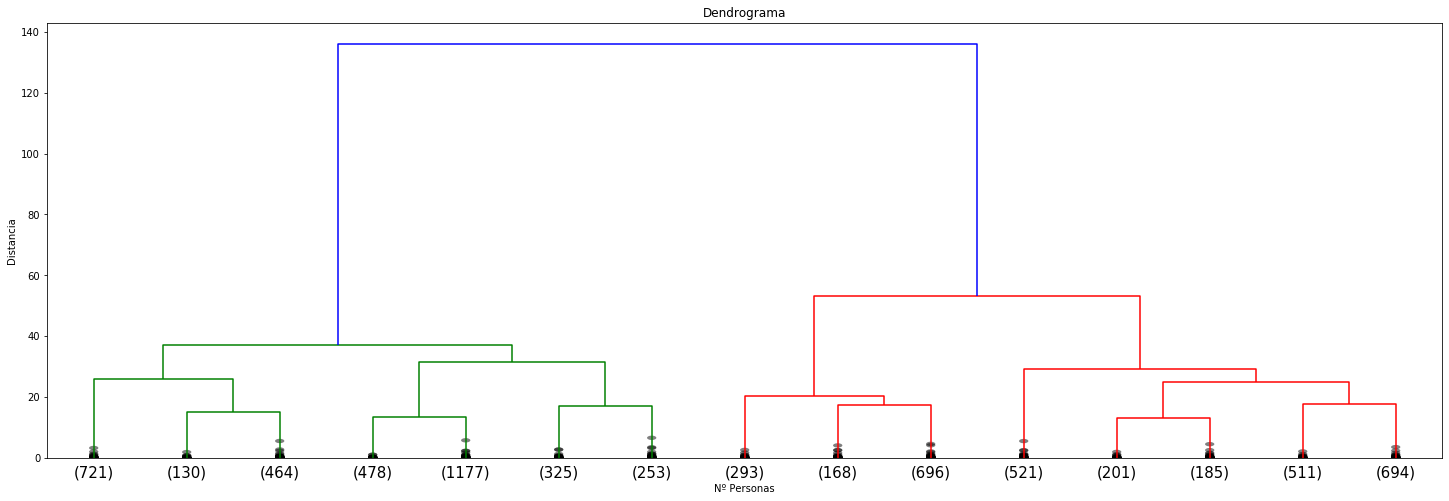

In [ ]:
#Obtención del dendrograma:

plt.figure(figsize=(25,8))
plt.title("Dendrograma")
plt.xlabel("Nº Personas")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=0., leaf_font_size=15.0, truncate_mode="lastp", p=15, show_leaf_counts=True,
           show_contracted=True) #'p=' cambia el nº de sub-cluster a mostrar.
plt.show()

Se observan 2 grandes grupos, aunque también podría considerarse generar 3 o 4 clusters.

[136.14356255  53.26634446  37.14342638  31.38638224  29.0970544
  26.0551098   24.8754433   20.41149297  17.68990367  17.28879614
  16.88605488  15.03709136  13.51304724  13.11404424  12.93594748]


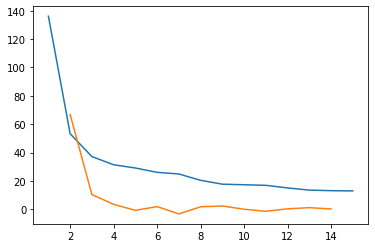

El número óptimo de cluster es 2


In [ ]:
#Método del codo:

last = Z[-15:,2]
last_rev = last[::-1]
print(last_rev)
idx = np.arange(1, len(last)+1)
plt.plot(idx, last_rev)

#Aceleración:
acc = np.diff(last,2)
acc_rev = acc[::-1]
plt.plot(idx[:-2]+1, acc_rev)
plt.show()
k = acc_rev.argmax() +2
print("El número óptimo de cluster es %s"%str(k))

Como se pretenden vender diferentes modelos de coches, se opta por una división en 3 clusters:

In [ ]:
##Usando el nº de cluster 'k':

k = 3
clusters = fcluster(Z, k, criterion="maxclust")

data_cluster_k3 = data.copy()

data_cluster_k3['Cluster'] = clusters
data_cluster_k3.head()

,Customer,Income,Location Code_Rural,Marital Status_Single,Cluster
0,BU79786,56274,0,0,3
1,AI49188,48767,0,0,3
2,HB64268,43836,1,1,1
3,OC83172,62902,1,0,3
4,XZ87318,55350,0,0,3


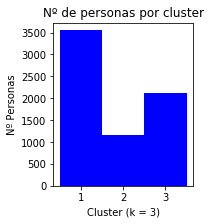

In [ ]:
#Histograma: número de personas en cada cluster:

plt.figure(figsize=(2.5, 3))
plt.hist(data_cluster_k3['Cluster'], align='left', color='blue', bins=[1,2,3,4])
plt.xlabel('Cluster (k = 3)')
plt.ylabel('Nº Personas')
plt.title('Nº de personas por cluster')
plt.show()

In [ ]:
data_cluster_k3.groupby('Cluster').mean()

,Income,Location Code_Rural,Marital Status_Single
Cluster,,,
1,30339.757610,0.199831,0.162909
2,88295.060501,0.295592,0.145203
3,63522.568182,0.290720,0.182765


In [ ]:
data_cluster_k3.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
1,3548.0,30339.757610,10287.499137,10037.0,22692.5,28917.0,38415.75,54878.0
2,1157.0,88295.060501,6683.333020,75909.0,82875.0,88340.0,93987.00,99981.0
3,2112.0,63522.568182,8339.260715,47122.0,56970.0,63033.5,70346.50,81491.0


Ahora sí se ha conseguido que el peso de los ingresos anuales sea determinante a la hora de crear los clusters. No obstante, no hay ninguno de ellos en el que predominen personas que viven en entornos rurales o sean solteras, por tanto, se va a probar con un mayor número de clusters.

#### k = 8

In [ ]:
data_balance = data_norm.copy()

In [ ]:
k = 8
clusters = fcluster(Z, k, criterion="maxclust")

data_cluster_k8 = data.copy()

data_cluster_k8['Cluster'] = clusters
data_cluster_k8.head()

,Customer,Income,Location Code_Rural,Marital Status_Single,Cluster
0,BU79786,56274,0,0,8
1,AI49188,48767,0,0,8
2,HB64268,43836,1,1,4
3,OC83172,62902,1,0,6
4,XZ87318,55350,0,0,8


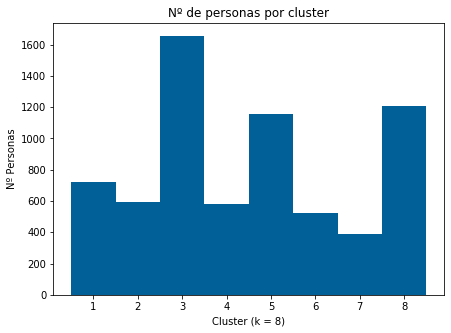

In [ ]:
#Histograma: número de personas en cada cluster:

plt.figure(figsize=(7, 5))
plt.hist(data_cluster_k8['Cluster'], align='left', color='#006097', bins=[1,2,3,4,5,6,7,8,9])
plt.xlabel('Cluster (k = 8)')
plt.ylabel('Nº Personas')
plt.title('Nº de personas por cluster')
plt.show()

In [ ]:
data_cluster_k8.groupby('Cluster').mean()

,Income,Location Code_Rural,Marital Status_Single
Cluster,,,
1,40825.188627,0.000000,0.000000
2,37128.890572,1.000000,0.000000
3,23602.507553,0.000000,0.000000
4,29574.027682,0.198962,1.000000
5,88295.060501,0.295592,0.145203
6,68468.543186,1.000000,0.000000
7,62117.603627,0.240933,1.000000
8,61834.156017,0.000000,0.000000


In [ ]:
data_cluster_k8.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
1,721.0,40825.188627,4086.580951,34062.0,37384.00,40516.0,44320.00,48448.0
2,594.0,37128.890572,10430.995212,10074.0,29538.75,37530.5,45700.25,54878.0
3,1655.0,23602.507553,5761.111099,10147.0,20149.00,23893.0,27906.50,33967.0
4,578.0,29574.027682,10352.260279,10037.0,22571.00,28867.5,37360.25,53703.0
5,1157.0,88295.060501,6683.333020,75909.0,82875.00,88340.0,93987.00,99981.0
6,521.0,68468.543186,7203.471671,55099.0,62120.00,68507.0,74965.00,81491.0
7,386.0,62117.603627,8996.514606,47122.0,54819.50,60920.0,69379.00,79681.0
8,1205.0,61834.156017,7718.041294,48534.0,55437.00,61146.0,68568.00,75774.0


### Descripción de cada Cluster:

* **Cluster-1**: las personas de este grupo tienen unos ingresos medios anuales de 40.825 €. Ninguna de ellas vive en entornos rurales y tampoco está soltera.
    * Podrían ser los destinatarios de una campaña de marketing de un **Monovolumen de precio medio**.


* **Cluster-2**: las personas de este grupo tienen unos ingresos medios anuales de poco más de 37.000 €; el 75% presenta ingresos superiores a 29.500 €. Todos los individuos de este cluster *viven en entornos rurales* y *no están solteros*.
    * Podrían ser los destinatarios de una campaña de marketing de un **Suv de precio medio**, ideal para carretera pero también para circular por caminos no asfaltados.


* **Cluster-3**: es el cluster más numeroso (24,3%). Las personas de este grupo tienen unos ingresos medios anuales de 23.600 €; menos del 25% supera los 28.000 €. Ninguna de ellas vive en entornos rurales y tampoco está soltera.
    * Podrían ser los destinatarios de una campaña de marketing de un **coche de pequeño o mediano tamaño y gama baja**.


* **Cluster-4**: las personas de este grupo tienen unos ingresos medios anuales de 29.500 €; solo el 25% supera los 37.000 € anuales. Todas ellas son *solteras* y en su mayoría (más del 80%) viven en entornos *no rurales*.
    * Podrían ser los destinatarios de una campaña de marketing de un **coche de pequeño tamaño, con acabados deportivos y de gama media**.


* **Cluster-5**: las personas de este grupo tienen unos ingresos medios anuales de casi 88.300 €; el ingreso más bajo en este cluster se sitúa en los 75.900 €. Solo el 14,5% de los individuos está soltero y el 70% vive en entornos no rurales. Este cluster es el tercero más numeroso, segmentando a un 17% del total de personas.
    * Podrían ser los destinatarios de una campaña de marketing de un **coche de medio y gran tamaño y de gama alta o superior**.


* **Cluster-6**: las personas de este grupo tienen unos ingresos medios anuales de, aproximadamente, 68.500 €; solo el 25% dispone de unos ingresos superiores a los 75.000 €. Todas estas personas *viven en entornos rurales* y *no están solteras*.
    * Podrían ser los destinatarios de una campaña de marketing de un **coche de gran tamaño y de gama media-alta o alta, como un 4x4 o un Suv**.


* **Cluster-7**: es el cluster menos numeroso (5,7%). Las personas de este grupo tienen unos ingresos medios anuales de 62.100 €; casi el 75% supera los 55.000 € anuales. Todos los individuos *son solteros* y el *24,1% vive en entornos rurales*.
    * Podrían ser los destinatarios de una campaña de marketing de un **Deportivo de gama alta**.


* **Cluster-8**: es el segundo grupo más numeroso, con un 17,7% del total de individuos. Las características de ingresos anuales son prácticamente iguales a las observadas en el cluster-7; la diferencia reside en que *ninguna de las personas vive en entornos rurales o es soltera*.
    * Podrían ser los destinatarios de una campaña de marketing de un **coche de tamaño medio o grande de gama media-alta, quizá una furgoneta familiar**.

Por último, un **Scater Plot** en 3 dimensiones. La forma singular de 4 barras verticales en cada una de las esquinas del plano horizontal se debe al hecho de que dos de las tres variables que se han tenido en cuenta son de origen categórico (sí/no) y han sido transformadas a valores numéricos (1 y 0).

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

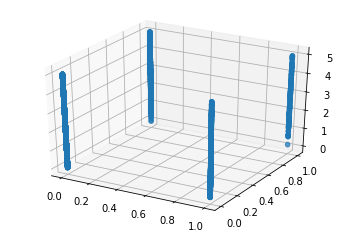

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs = data_balance["Marital Status_Single"], ys = data_balance["Location Code_Rural"], zs = data_balance["Income"])